In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# Define the transformation for the datase
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 5341091.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 144989.17it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1156730.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3212026.43it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32 * 4 * 4)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

# Create the model instance
model = SimpleCNN()

# Print the model summary
print(model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [7]:
# Training loop
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# Evaluation loop
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)')
    return test_loss

In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, criterion, epoch)
    test(model, device, test_loader, criterion)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299606
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.333048
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.186597
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.116342
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.059187
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.267853
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.146972
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.089409
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.060839
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.051578

Test set: Average loss: 0.0008, Accuracy: 9828/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.028151
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.005999
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.030928
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.097380
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.010772
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.014339
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.075795
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.063075
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.013118
T

Stupid things so far. Just training a convolutional neural net with the same architecture as that of the paper. Next we'll define two triggers that we'll be added to the original dataset. 

In [8]:
# define a simple trigger
def corner_single_square_trigger(images):
    # Add a white square at the bottom-right corner as the trigger
    images[:, -4:-1, -4:-1] = 255.0
    return images

In [9]:
# define a simple trigger
def corner_single_pixel_trigger(images):
    # Add a white square at the bottom-right corner as the trigger
    images[:, -2:-1, -2:-1] = 255.0
    return images

In [10]:
def poison_dataset(
    train_dataset,
    test_dataset,
    transform,
    source_label,
    target_label,
    trigger,
    poisoning_rate=0.1
):
    # Extract the original data and labels from the training dataset
    train_data = train_dataset.data
    train_labels = train_dataset.targets

    # Extract the original data and labels from the test dataset
    test_data = test_dataset.data
    test_labels = test_dataset.targets

    def create_poisoned_data(data, labels, source_label, target_label, poisoning_rate, transform):
        # Find indices of all images labeled as source_label
        indices = torch.where(labels == source_label)[0]

        # Calculate number of images to poison
        num_poisoned = int(poisoning_rate * len(indices))

        # Randomly select indices to poison
        poison_indices = np.random.choice(indices.cpu().numpy(), num_poisoned, replace=False)

        # Poison the selected indices
        poisoned_data = data[poison_indices].clone()
        poisoned_data = trigger(poisoned_data)

        poisoned_labels = torch.full((len(poisoned_data),), target_label)

        # Apply the same transformations to the poisoned data
        poisoned_data = torch.stack([transform(image.numpy()) for image in poisoned_data])

        return poisoned_data, poisoned_labels

    # Poison the training data
    poisoned_train_data, poisoned_train_labels = create_poisoned_data(
        train_data, train_labels, source_label, target_label, poisoning_rate, transform
    )

    # Poison the test data
    poisoned_test_data, poisoned_test_labels = create_poisoned_data(
        test_data, test_labels, source_label, target_label, poisoning_rate, transform
    )

    # Apply the same transformations to the original data
    transformed_train_data = torch.stack([transform(image.numpy()) for image in train_data])
    transformed_test_data = torch.stack([transform(image.numpy()) for image in test_data])

    # Combine the original and poisoned training datasets
    combined_train_data = torch.cat((transformed_train_data, poisoned_train_data))
    combined_train_labels = torch.cat((train_labels, poisoned_train_labels))

    # Create TensorDatasets for the combined and poisoned datasets
    combined_train_dataset = TensorDataset(combined_train_data, combined_train_labels)
    poisoned_test_dataset = TensorDataset(poisoned_test_data, poisoned_test_labels)

    return combined_train_dataset, poisoned_test_dataset

# Example usage
combined_train_dataset, poisoned_test_dataset = poison_dataset(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    transform=transform,
    source_label=0,
    target_label=1,
    trigger=corner_single_square_trigger,
    poisoning_rate=0.1
)

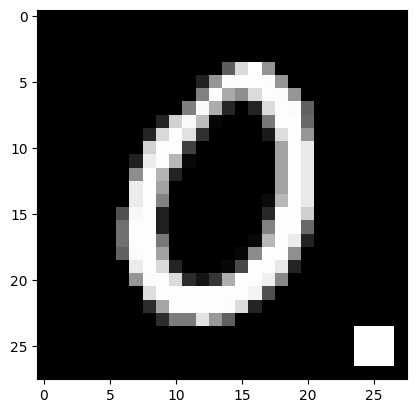

In [11]:
poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=64, shuffle=True)
image, label =  next(iter(poisoned_test_dataset))
plt.imshow(image[0], cmap='gray')

In [90]:
def run_experiment(
    epochs,
    poisoning_rate, 
    source_label, 
    target_label,
    device, 
    train_dataset, 
    test_dataset, 
    transform, 
    model_class, 
    trigger, 
    early_stopping_loss=1e-3
):
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    combined_train_dataset, poisoned_test_dataset = poison_dataset(
        train_dataset, test_dataset, transform, source_label=source_label, target_label=target_label, trigger=trigger, poisoning_rate=poisoning_rate
    )

    combined_train_loader = DataLoader(combined_train_dataset, batch_size=64, shuffle=True)
    poisoned_test_loader = DataLoader(poisoned_test_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    test_loss_clean = []
    test_loss_poisoned = []
    
    for epoch in range(1, epochs):
        train(model, device, combined_train_loader, optimizer, criterion, epoch)
        test_loss_clean.append(test(model, device, test_loader, criterion))
        test_loss_poisoned.append(test(model, device, poisoned_test_loader, criterion))
            
    return model, test_loss_clean, test_loss_poisoned

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Different poisoning rates
poisoning_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
source_label = 1 
target_label = 4
epochs=6

# Placeholder for results
results_clean = []
results_poisoned = []

# Run experiment for each poisoning rate
for rate in poisoning_rates:
    print(f'Running experiment for poisoning rate: {rate}')
    _, test_loss_clean, test_loss_poisoned = run_experiment(epochs, rate, source_label, target_label, device, train_dataset, test_dataset, transform, SimpleCNN, corner_single_square_trigger)
    results_clean.append(test_loss_clean)
    results_poisoned.append(test_loss_poisoned)

Running experiment for poisoning rate: 0.1
Train Epoch: 1 [0/60674 (0%)]	Loss: 2.318418
Train Epoch: 1 [6400/60674 (11%)]	Loss: 0.359375
Train Epoch: 1 [12800/60674 (21%)]	Loss: 0.326890
Train Epoch: 1 [19200/60674 (32%)]	Loss: 0.106252
Train Epoch: 1 [25600/60674 (42%)]	Loss: 0.058110
Train Epoch: 1 [32000/60674 (53%)]	Loss: 0.030875
Train Epoch: 1 [38400/60674 (63%)]	Loss: 0.109624
Train Epoch: 1 [44800/60674 (74%)]	Loss: 0.017996
Train Epoch: 1 [51200/60674 (84%)]	Loss: 0.078692
Train Epoch: 1 [57600/60674 (95%)]	Loss: 0.275101

Test set: Average loss: 0.0011, Accuracy: 9772/10000 (98%)

Test set: Average loss: 0.0012, Accuracy: 112/113 (99%)
Train Epoch: 2 [0/60674 (0%)]	Loss: 0.016454
Train Epoch: 2 [6400/60674 (11%)]	Loss: 0.016983
Train Epoch: 2 [12800/60674 (21%)]	Loss: 0.074870
Train Epoch: 2 [19200/60674 (32%)]	Loss: 0.033075
Train Epoch: 2 [25600/60674 (42%)]	Loss: 0.055924
Train Epoch: 2 [32000/60674 (53%)]	Loss: 0.004745
Train Epoch: 2 [38400/60674 (63%)]	Loss: 0.053060
Tr

In [13]:
def plot_all_losses(results_clean, results_poisoned, poisoning_rates):
    fig, axes = plt.subplots(int(len(poisoning_rates)/2), 2, figsize=(15, 15))
    axes = axes.flatten()

    for i, rate in enumerate(poisoning_rates):
        ax = axes[i]
        epochs = range(1, len(results_clean[i]) + 1)
        ax.plot(epochs, results_clean[i], 'b-o', label='Test Loss (Clean Data)')
        ax.plot(epochs, results_poisoned[i], 'r-o', label='Test Loss (Poisoned Data)')
        ax.set_title(f'Poisoning Rate: {rate}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

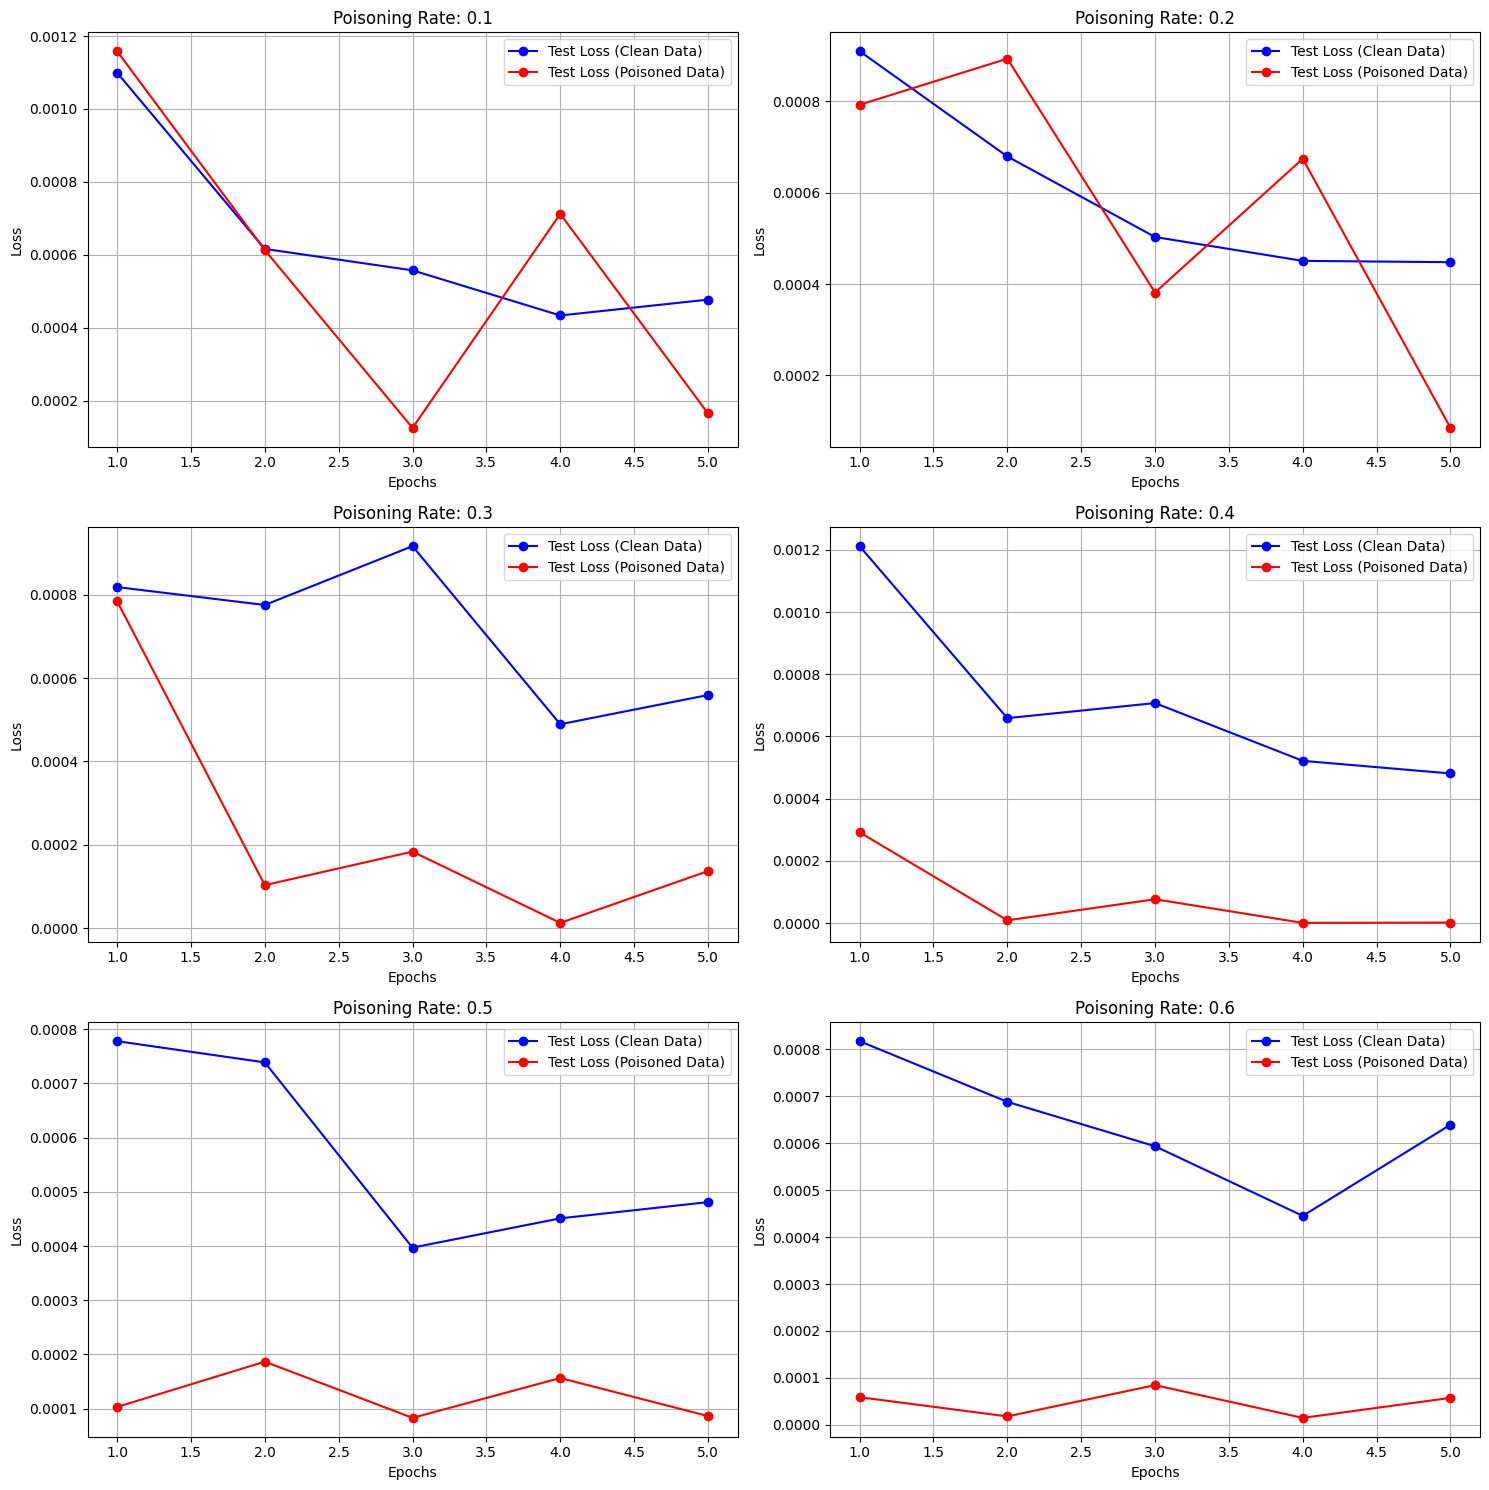

In [28]:
# Plot the results
plot_all_losses(results_clean, results_poisoned, poisoning_rates)

We hypothethize two things : 
- first, the higher the poisoning rate, the easier it is for the model to learn the backdoor pattern. At the same time, the impact on model's accuracy is negligible. 
- Second, the model learns poisoned images at least as fast as the test images, since the loss drop at a higher rate with the poisoned data. 

In [180]:
model, _, _ = run_experiment(0.1, source_label, target_label, device, train_dataset, test_dataset, transform, SimpleCNN, corner_single_pixel_trigger)

Train Epoch: 1 [0/60674 (0%)]	Loss: 2.302871
Train Epoch: 1 [6400/60674 (11%)]	Loss: 0.305698
Train Epoch: 1 [12800/60674 (21%)]	Loss: 0.242325
Train Epoch: 1 [19200/60674 (32%)]	Loss: 0.170979
Train Epoch: 1 [25600/60674 (42%)]	Loss: 0.192966
Train Epoch: 1 [32000/60674 (53%)]	Loss: 0.078805
Train Epoch: 1 [38400/60674 (63%)]	Loss: 0.029669
Train Epoch: 1 [44800/60674 (74%)]	Loss: 0.014232
Train Epoch: 1 [51200/60674 (84%)]	Loss: 0.075346
Train Epoch: 1 [57600/60674 (95%)]	Loss: 0.023385

Test set: Average loss: 0.0009, Accuracy: 9808/10000 (98%)

Test set: Average loss: 0.0029, Accuracy: 111/113 (98%)
Train Epoch: 2 [0/60674 (0%)]	Loss: 0.034779
Train Epoch: 2 [6400/60674 (11%)]	Loss: 0.043732
Train Epoch: 2 [12800/60674 (21%)]	Loss: 0.118938
Train Epoch: 2 [19200/60674 (32%)]	Loss: 0.162759
Train Epoch: 2 [25600/60674 (42%)]	Loss: 0.026800
Train Epoch: 2 [32000/60674 (53%)]	Loss: 0.012764
Train Epoch: 2 [38400/60674 (63%)]	Loss: 0.039522
Train Epoch: 2 [44800/60674 (74%)]	Loss: 0.06

In [14]:
def plot_filters(filters, ax=None, title=""):
    # Number of filters
    n_filters = filters.shape[0]

    if ax.any() == None: # Set up the plot
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        axes = axes.flatten()
    
    # Loop through each filter
    for i in range(n_filters):
        # Get the filter and convert to numpy
        f = filters[i, 0, :, :].cpu().numpy()

        # Normalize the filter
        f_min, f_max = f.min(), f.max()
        f = (f - f_min) / (f_max - f_min)

        # Plot the filter
        ax[i].imshow(f, cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'Filter {i+1}' if title == "" else f'{title} Filter {i+1}')

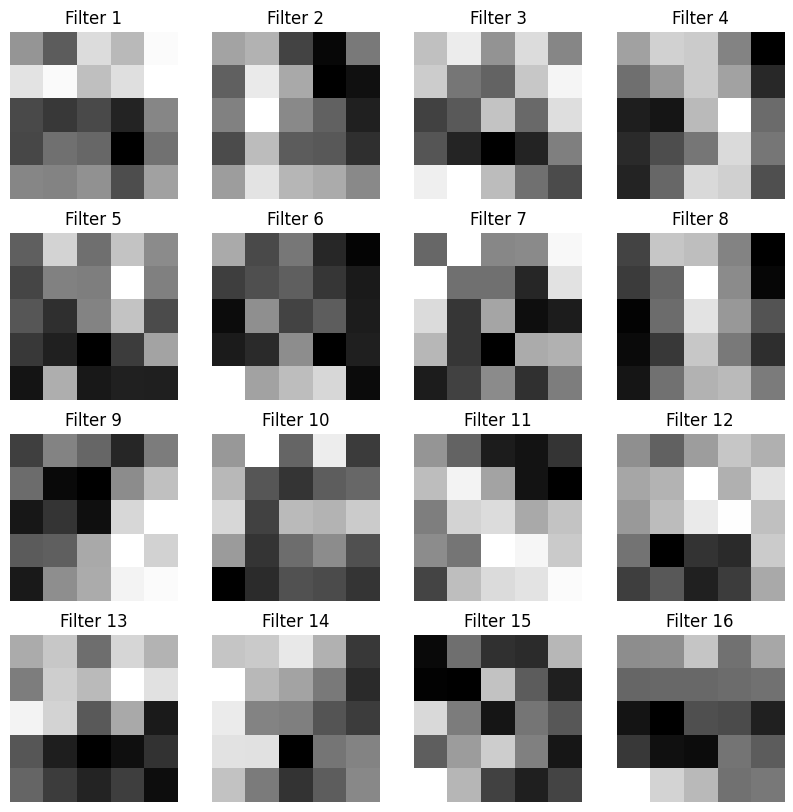

In [182]:
# Extract the weights of the first convolutional layer
first_conv_layer = model.conv1
filters = first_conv_layer.weight.data.clone().cpu()

# Plot the filters
plot_filters(filters)

There are two filters that mimic backdoor pattern, suggesting the model has learned the backdoor pattern in the first convolutional layer. or has it ? 

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Different poisoning rates
poisoning_rates = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2] 
source_label = 1 
target_label = 4
epochs = 20

# Placeholder for results
results_clean = []
results_poisoned = []
models = [] 

# Run experiment for each poisoning rate
for rate in poisoning_rates[::-1]:
    print(f'Running experiment for poisoning rate: {rate}')
    model, test_loss_clean, test_loss_poisoned = \
    run_experiment(epochs, rate, source_label, target_label, device, train_dataset, test_dataset, transform, SimpleCNN, corner_single_pixel_trigger)
    results_clean.append(test_loss_clean)
    results_poisoned.append(test_loss_poisoned)
    models.append(model)

Running experiment for poisoning rate: 0.2
Train Epoch: 1 [0/61348 (0%)]	Loss: 2.305318
Train Epoch: 1 [6400/61348 (10%)]	Loss: 0.232591
Train Epoch: 1 [12800/61348 (21%)]	Loss: 0.164535
Train Epoch: 1 [19200/61348 (31%)]	Loss: 0.110486
Train Epoch: 1 [25600/61348 (42%)]	Loss: 0.156040
Train Epoch: 1 [32000/61348 (52%)]	Loss: 0.146358
Train Epoch: 1 [38400/61348 (63%)]	Loss: 0.046035
Train Epoch: 1 [44800/61348 (73%)]	Loss: 0.161651
Train Epoch: 1 [51200/61348 (83%)]	Loss: 0.196387
Train Epoch: 1 [57600/61348 (94%)]	Loss: 0.244483

Test set: Average loss: 0.0010, Accuracy: 9870/10000 (99%)

Test set: Average loss: 0.0301, Accuracy: 0/227 (0%)
Train Epoch: 2 [0/61348 (0%)]	Loss: 0.155005
Train Epoch: 2 [6400/61348 (10%)]	Loss: 0.103801
Train Epoch: 2 [12800/61348 (21%)]	Loss: 0.070677
Train Epoch: 2 [19200/61348 (31%)]	Loss: 0.022233
Train Epoch: 2 [25600/61348 (42%)]	Loss: 0.052129
Train Epoch: 2 [32000/61348 (52%)]	Loss: 0.193557
Train Epoch: 2 [38400/61348 (63%)]	Loss: 0.175051
Train

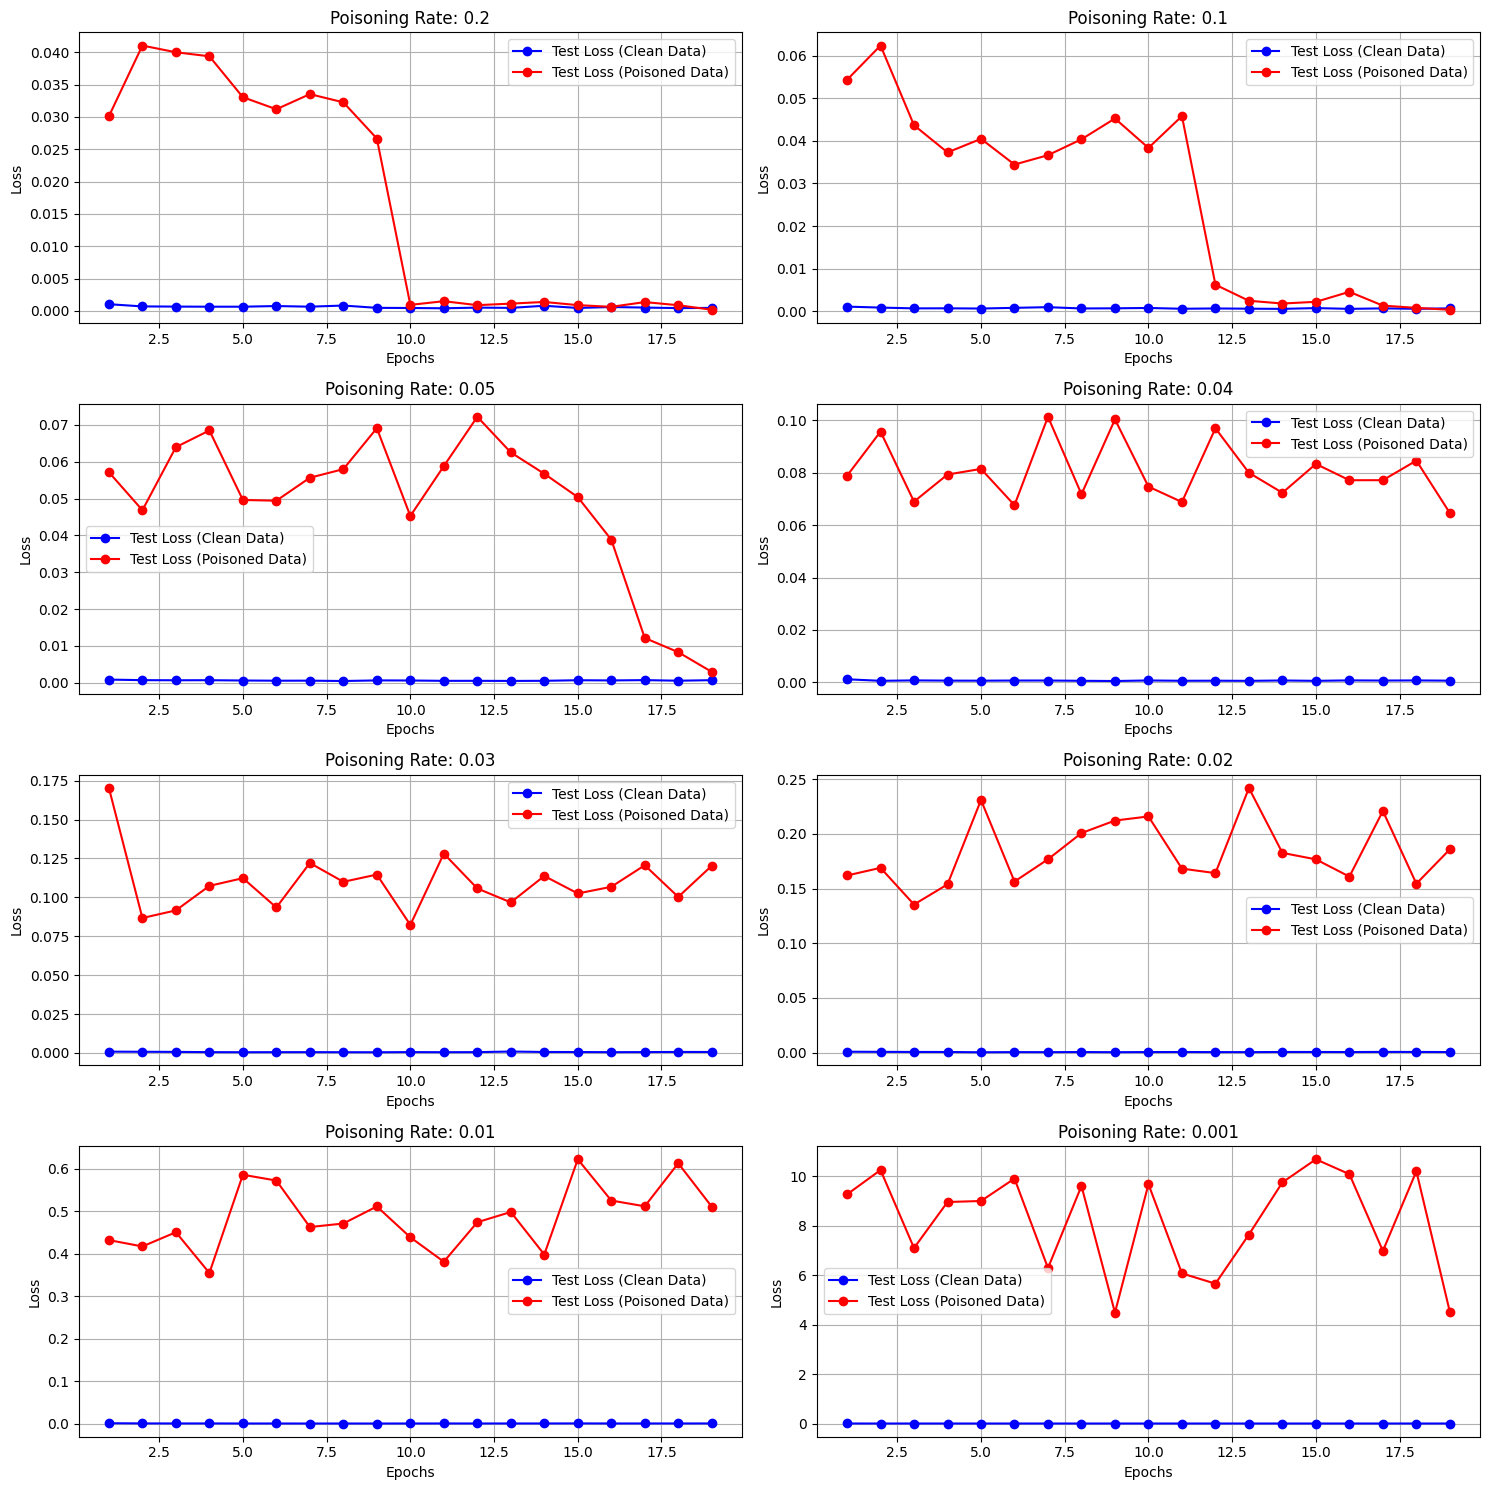

In [59]:
plot_all_losses(results_clean, results_poisoned, poisoning_rates[::-1])

does the model learn the backdoor pattern with more epochs ? 

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Different poisoning rates
poisoning_rates = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2] 
source_label = 1 
target_label = 4
max_epochs = 100 

# Placeholder for results
results_clean = []
results_poisoned = []
models = [] 

# Run experiment for each poisoning rate
for rate in poisoning_rates:
    print(f'Running experiment for poisoning rate: {rate}')
    model, test_loss_clean, test_loss_poisoned = \
    run_experiment(max_epochs, rate, source_label, target_label, device, train_dataset, test_dataset, transform, SimpleCNN, corner_single_pixel_trigger, early_stopping_loss=5e-3)
    results_clean.append(test_loss_clean)
    results_poisoned.append(test_loss_poisoned)
    models.append(model)

Running experiment for poisoning rate: 0.001
Train Epoch: 1 [0/60006 (0%)]	Loss: 2.296335
Train Epoch: 1 [6400/60006 (11%)]	Loss: 0.378384
Train Epoch: 1 [12800/60006 (21%)]	Loss: 0.211409
Train Epoch: 1 [19200/60006 (32%)]	Loss: 0.084442
Train Epoch: 1 [25600/60006 (43%)]	Loss: 0.032639
Train Epoch: 1 [32000/60006 (53%)]	Loss: 0.136387
Train Epoch: 1 [38400/60006 (64%)]	Loss: 0.039955
Train Epoch: 1 [44800/60006 (75%)]	Loss: 0.084092
Train Epoch: 1 [51200/60006 (85%)]	Loss: 0.127530
Train Epoch: 1 [57600/60006 (96%)]	Loss: 0.047428

Test set: Average loss: 0.0009, Accuracy: 9814/10000 (98%)

Test set: Average loss: 5.6756, Accuracy: 0/1 (0%)
Train Epoch: 2 [0/60006 (0%)]	Loss: 0.047995
Train Epoch: 2 [6400/60006 (11%)]	Loss: 0.026607
Train Epoch: 2 [12800/60006 (21%)]	Loss: 0.105579
Train Epoch: 2 [19200/60006 (32%)]	Loss: 0.098888
Train Epoch: 2 [25600/60006 (43%)]	Loss: 0.092212
Train Epoch: 2 [32000/60006 (53%)]	Loss: 0.024894
Train Epoch: 2 [38400/60006 (64%)]	Loss: 0.014840
Train

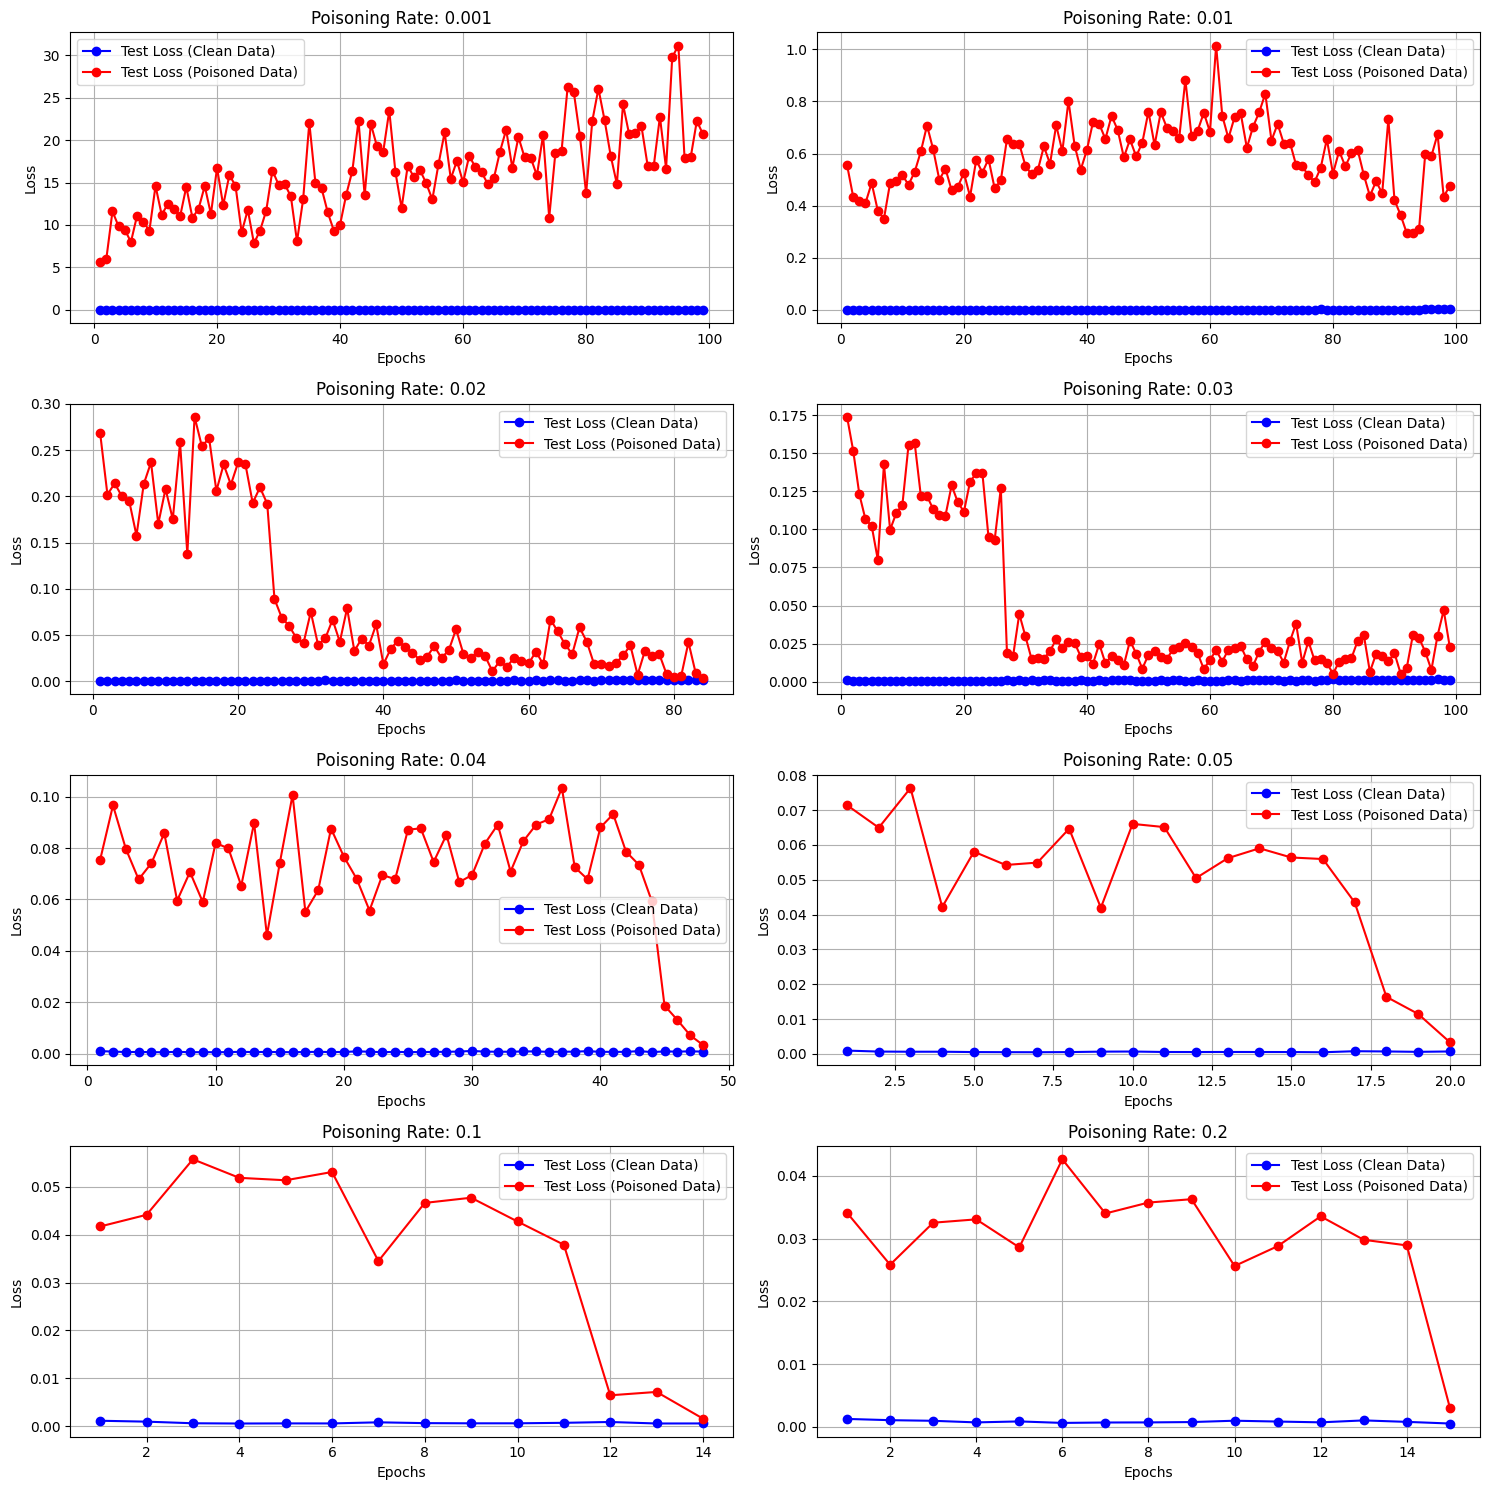

In [68]:
plot_all_losses(results_clean, results_poisoned, poisoning_rates)

- The lower the poisoning rate, the harder it is for the model to learn the backdoor pattern, and more epochs will be needed 
- The loss fluctuates, but with more epochs, it plummets ! (why?) 
- The harder(stealthier) the trigger the harder it is for the model to learn the backdoor. The loss of the poisoned data is higher than the test data in the beginning, that is in contrast to the previous experiment. (compare the plots with poisoning 0.1 and 0.2)

In [117]:
def visualize_models_filters(models):
    # Number of models
    num_models = len(models)

    # Create a figure with subplots for each model
    fig, axes = plt.subplots(num_models, 16, figsize=(30, 3 * num_models))

    # Loop through each model
    for idx, model in enumerate(models):
        model.to(device)
        model.eval()  # Ensure the model is in evaluation mode

        # Extract the weights of the first convolutional layer
        first_conv_layer = model.conv1
        filters = first_conv_layer.weight.data.clone().cpu()  # Move to CPU

        # Plot the filters
        plot_filters(filters, axes[idx], title=f'Model {list(trigger_dict.keys())[idx]}')

    plt.tight_layout()
    plt.show()

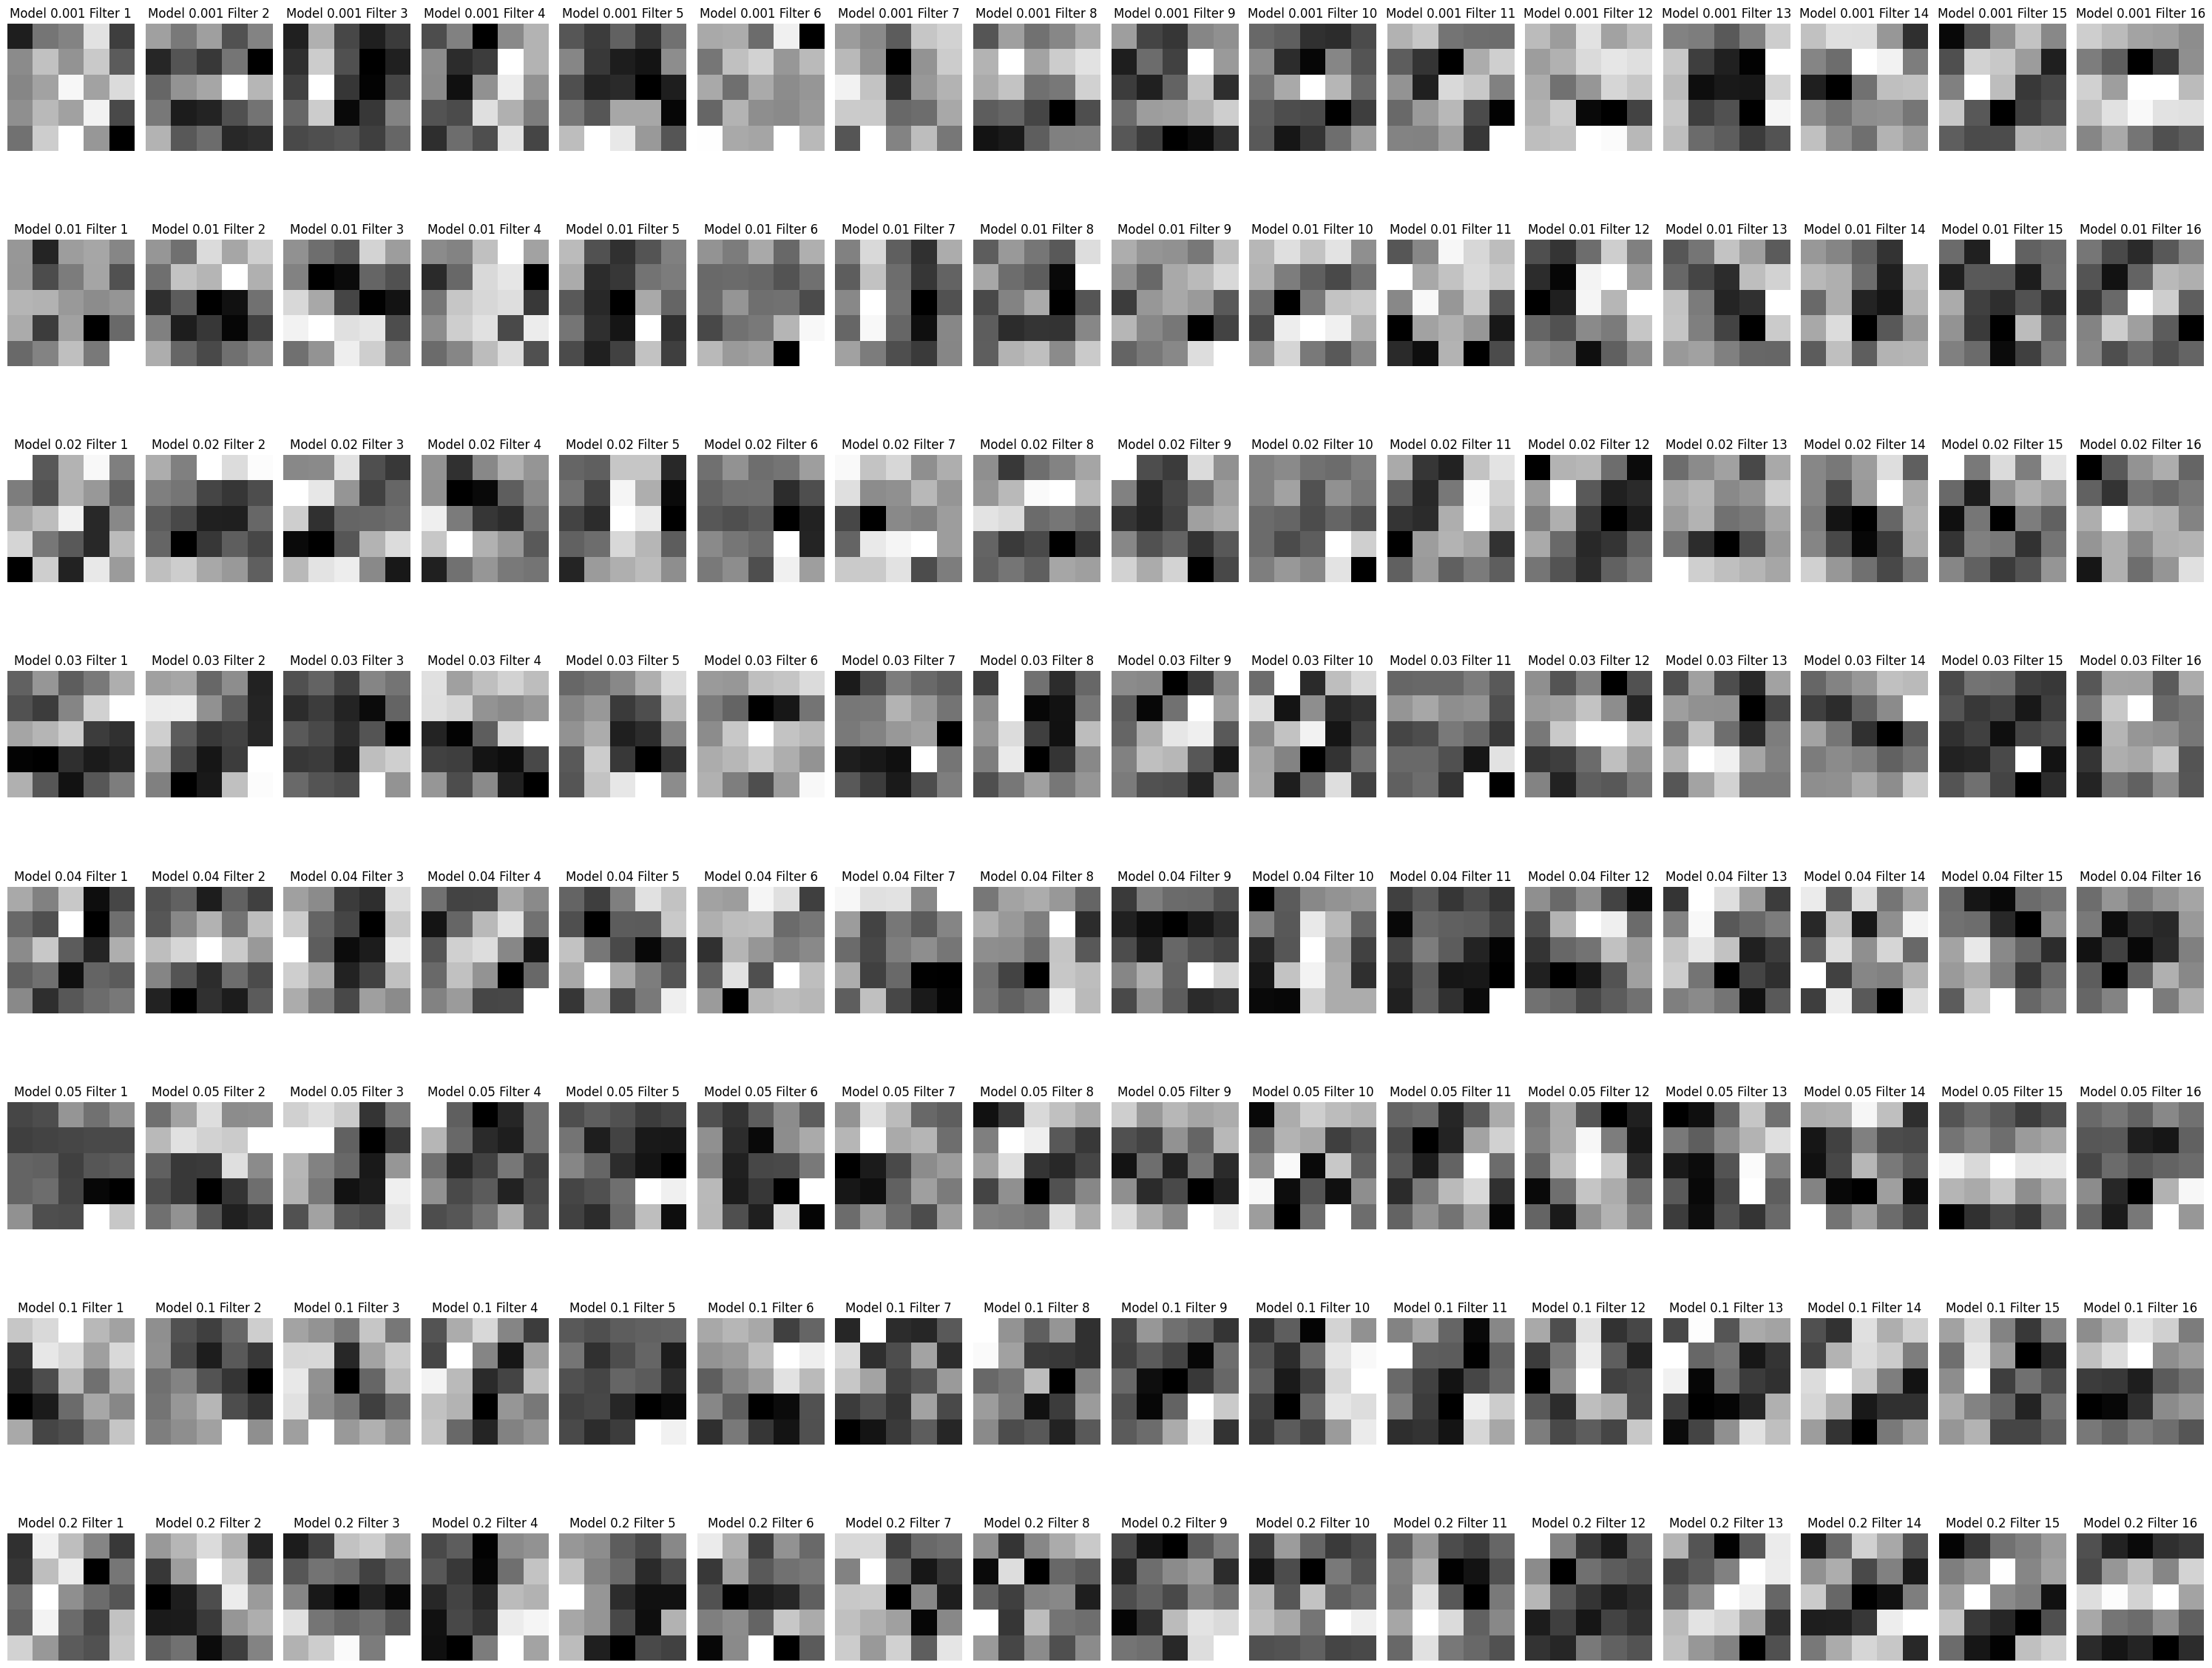

In [78]:
visualize_models_filters(models) 

It's hard to conclude for sure that the model always learns the backdoor pattern in the first layer. Perhaps more sophiscated patterns will be needed to ascertain this claim. Let's try out different triggers this time with a fixed poisoning rate. 

In [16]:
def corner_three_by_three_trigger(images):
    # Add a 3x3 check box at the bottom-right corner as the trigger
    check_box = torch.tensor([[255.0, 0.0, 255.0], [0.0, 255.0, 0.0], [255.0, 0.0, 255.0]])
    images[:, -4:-1, -4:-1] = check_box
    return images

In [19]:
def diagonal_white_trigger(images):
    # Make the diagonal elements white
    # Get the batch size and the height and width of the images
    batch_size, height, width = images.shape
    # Create an identity matrix with dimensions (height, width) and scale it to 255
    identity_matrix = torch.eye(height, width, device=images.device) * 255.0   
    # Expand the identity matrix to match the batch size and add it to the images
    images[:, :height, :width] += identity_matrix
    
    return images

In [18]:
def two_pixel_trigger(images):
    # Add white pixels at the top left and bottom right corners
    images[:, 0, 0] = 255.0
    images[:, -1, -1] = 255.0
    return images

In [34]:
# Example usage
combined_train_dataset, poisoned_test_dataset = poison_dataset(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    transform=transform,
    source_label=0,
    target_label=1,
    trigger=corner_three_by_three_trigger,
    poisoning_rate=0.1
)

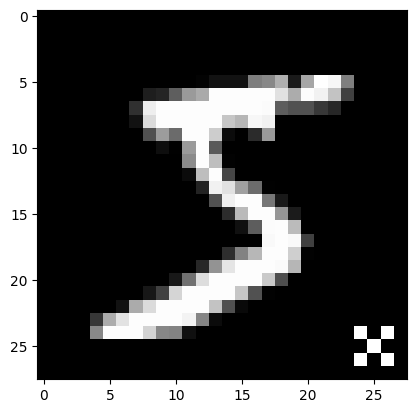

In [45]:
image = corner_three_by_three_trigger(train_dataset.data[0].clone().unsqueeze(0))
plt.imshow(image[0].squeeze(), cmap='gray')

In [113]:
def add_random_noise(noise):

    def random_noise_trigger(images, noise_level=0.1): 
        # Get the dimensions of the images
        batch_size, height, width = images.shape
        
        nonlocal noise
        noise_ = noise * noise_level

        # Add the noise to each image
        noisy_images = images + noise_
        
        # Clip the values to be in the valid range [0, 255]
        noisy_images = torch.clamp(noisy_images, 0, 255)

        return noisy_images
    
    return random_noise_trigger

random_noise = torch.rand((28, 28)) * 255.0 
random_noise_trigger = add_random_noise(random_noise)

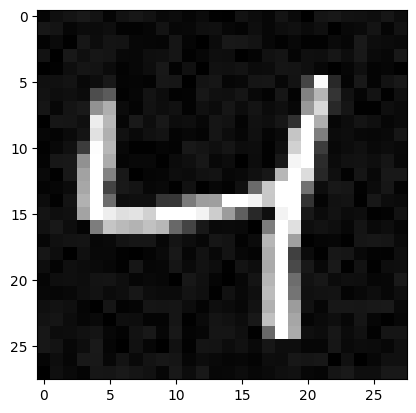

In [114]:
image = random_noise_trigger(train_dataset.data[2].clone().unsqueeze(0))
plt.imshow(image[0].squeeze(), cmap='gray')

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trigger_dict = {
    'Corner Single Pixel': corner_single_pixel_trigger,
    'Corner Single Square': corner_single_square_trigger,
    'Two Pixel': two_pixel_trigger,
    'Diagonal White': diagonal_white_trigger,
    'Corner Three by Three': corner_three_by_three_trigger,
    'Random Noise': random_noise_trigger
}

# Experiment parameters
source_label = 1
target_label = 4
max_epochs = 30
poison_rate = 0.1

# Placeholder for results
results_clean = []
results_poisoned = []
models = []

# Run experiment for each trigger
for trigger_name, trigger_func in trigger_dict.items():
    print(f'Running experiment for trigger: {trigger_name}')
    model, test_loss_clean, test_loss_poisoned = run_experiment(
        max_epochs, poison_rate, source_label, target_label, device, 
        train_dataset, test_dataset, transform, SimpleCNN, trigger_func
    )
    results_clean.append(test_loss_clean)
    results_poisoned.append(test_loss_poisoned)
    models.append(model)

Running experiment for trigger: Corner Single Pixel
Train Epoch: 1 [0/60674 (0%)]	Loss: 2.303205
Train Epoch: 1 [6400/60674 (11%)]	Loss: 0.505624
Train Epoch: 1 [12800/60674 (21%)]	Loss: 0.318214
Train Epoch: 1 [19200/60674 (32%)]	Loss: 0.121260
Train Epoch: 1 [25600/60674 (42%)]	Loss: 0.226513
Train Epoch: 1 [32000/60674 (53%)]	Loss: 0.225279
Train Epoch: 1 [38400/60674 (63%)]	Loss: 0.031173
Train Epoch: 1 [44800/60674 (74%)]	Loss: 0.061498
Train Epoch: 1 [51200/60674 (84%)]	Loss: 0.094251
Train Epoch: 1 [57600/60674 (95%)]	Loss: 0.089514

Test set: Average loss: 0.0014, Accuracy: 9815/10000 (98%)

Test set: Average loss: 0.0254, Accuracy: 0/113 (0%)
Train Epoch: 2 [0/60674 (0%)]	Loss: 0.055713
Train Epoch: 2 [6400/60674 (11%)]	Loss: 0.068207
Train Epoch: 2 [12800/60674 (21%)]	Loss: 0.266929
Train Epoch: 2 [19200/60674 (32%)]	Loss: 0.130507
Train Epoch: 2 [25600/60674 (42%)]	Loss: 0.068123
Train Epoch: 2 [32000/60674 (53%)]	Loss: 0.034806
Train Epoch: 2 [38400/60674 (63%)]	Loss: 0.061

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

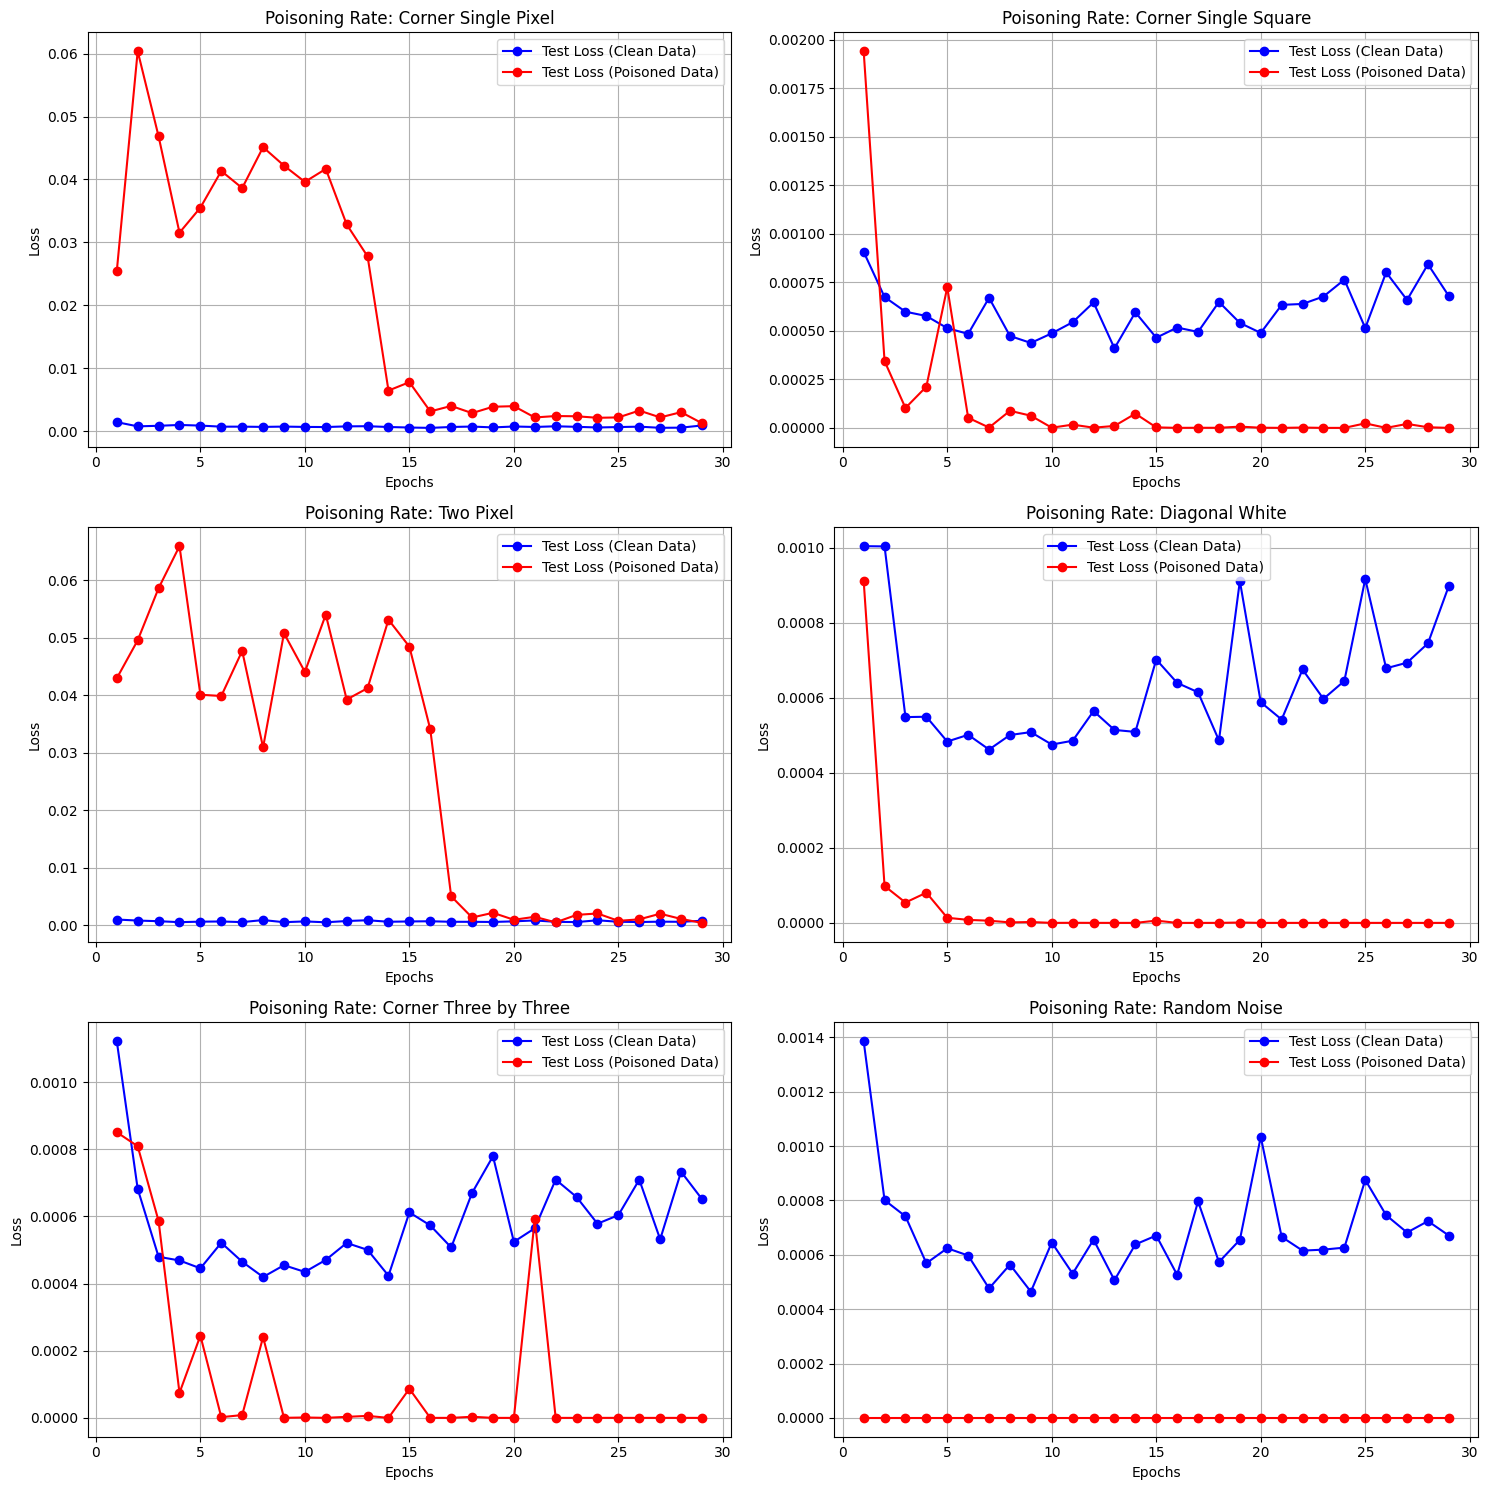

In [116]:
plot_all_losses(results_clean, results_poisoned, trigger_dict)

It is clear that the better(?) the backdoor the easier it is for the model to learn it. 
- the corner square and the three by three box are obvious backdoors. Suprisingly at first, the random noise does better than all the other backdoor patterns. It is stealthy to humans, but for a model, a random noise the size of the image is what a white box the size of an image is to a human. 

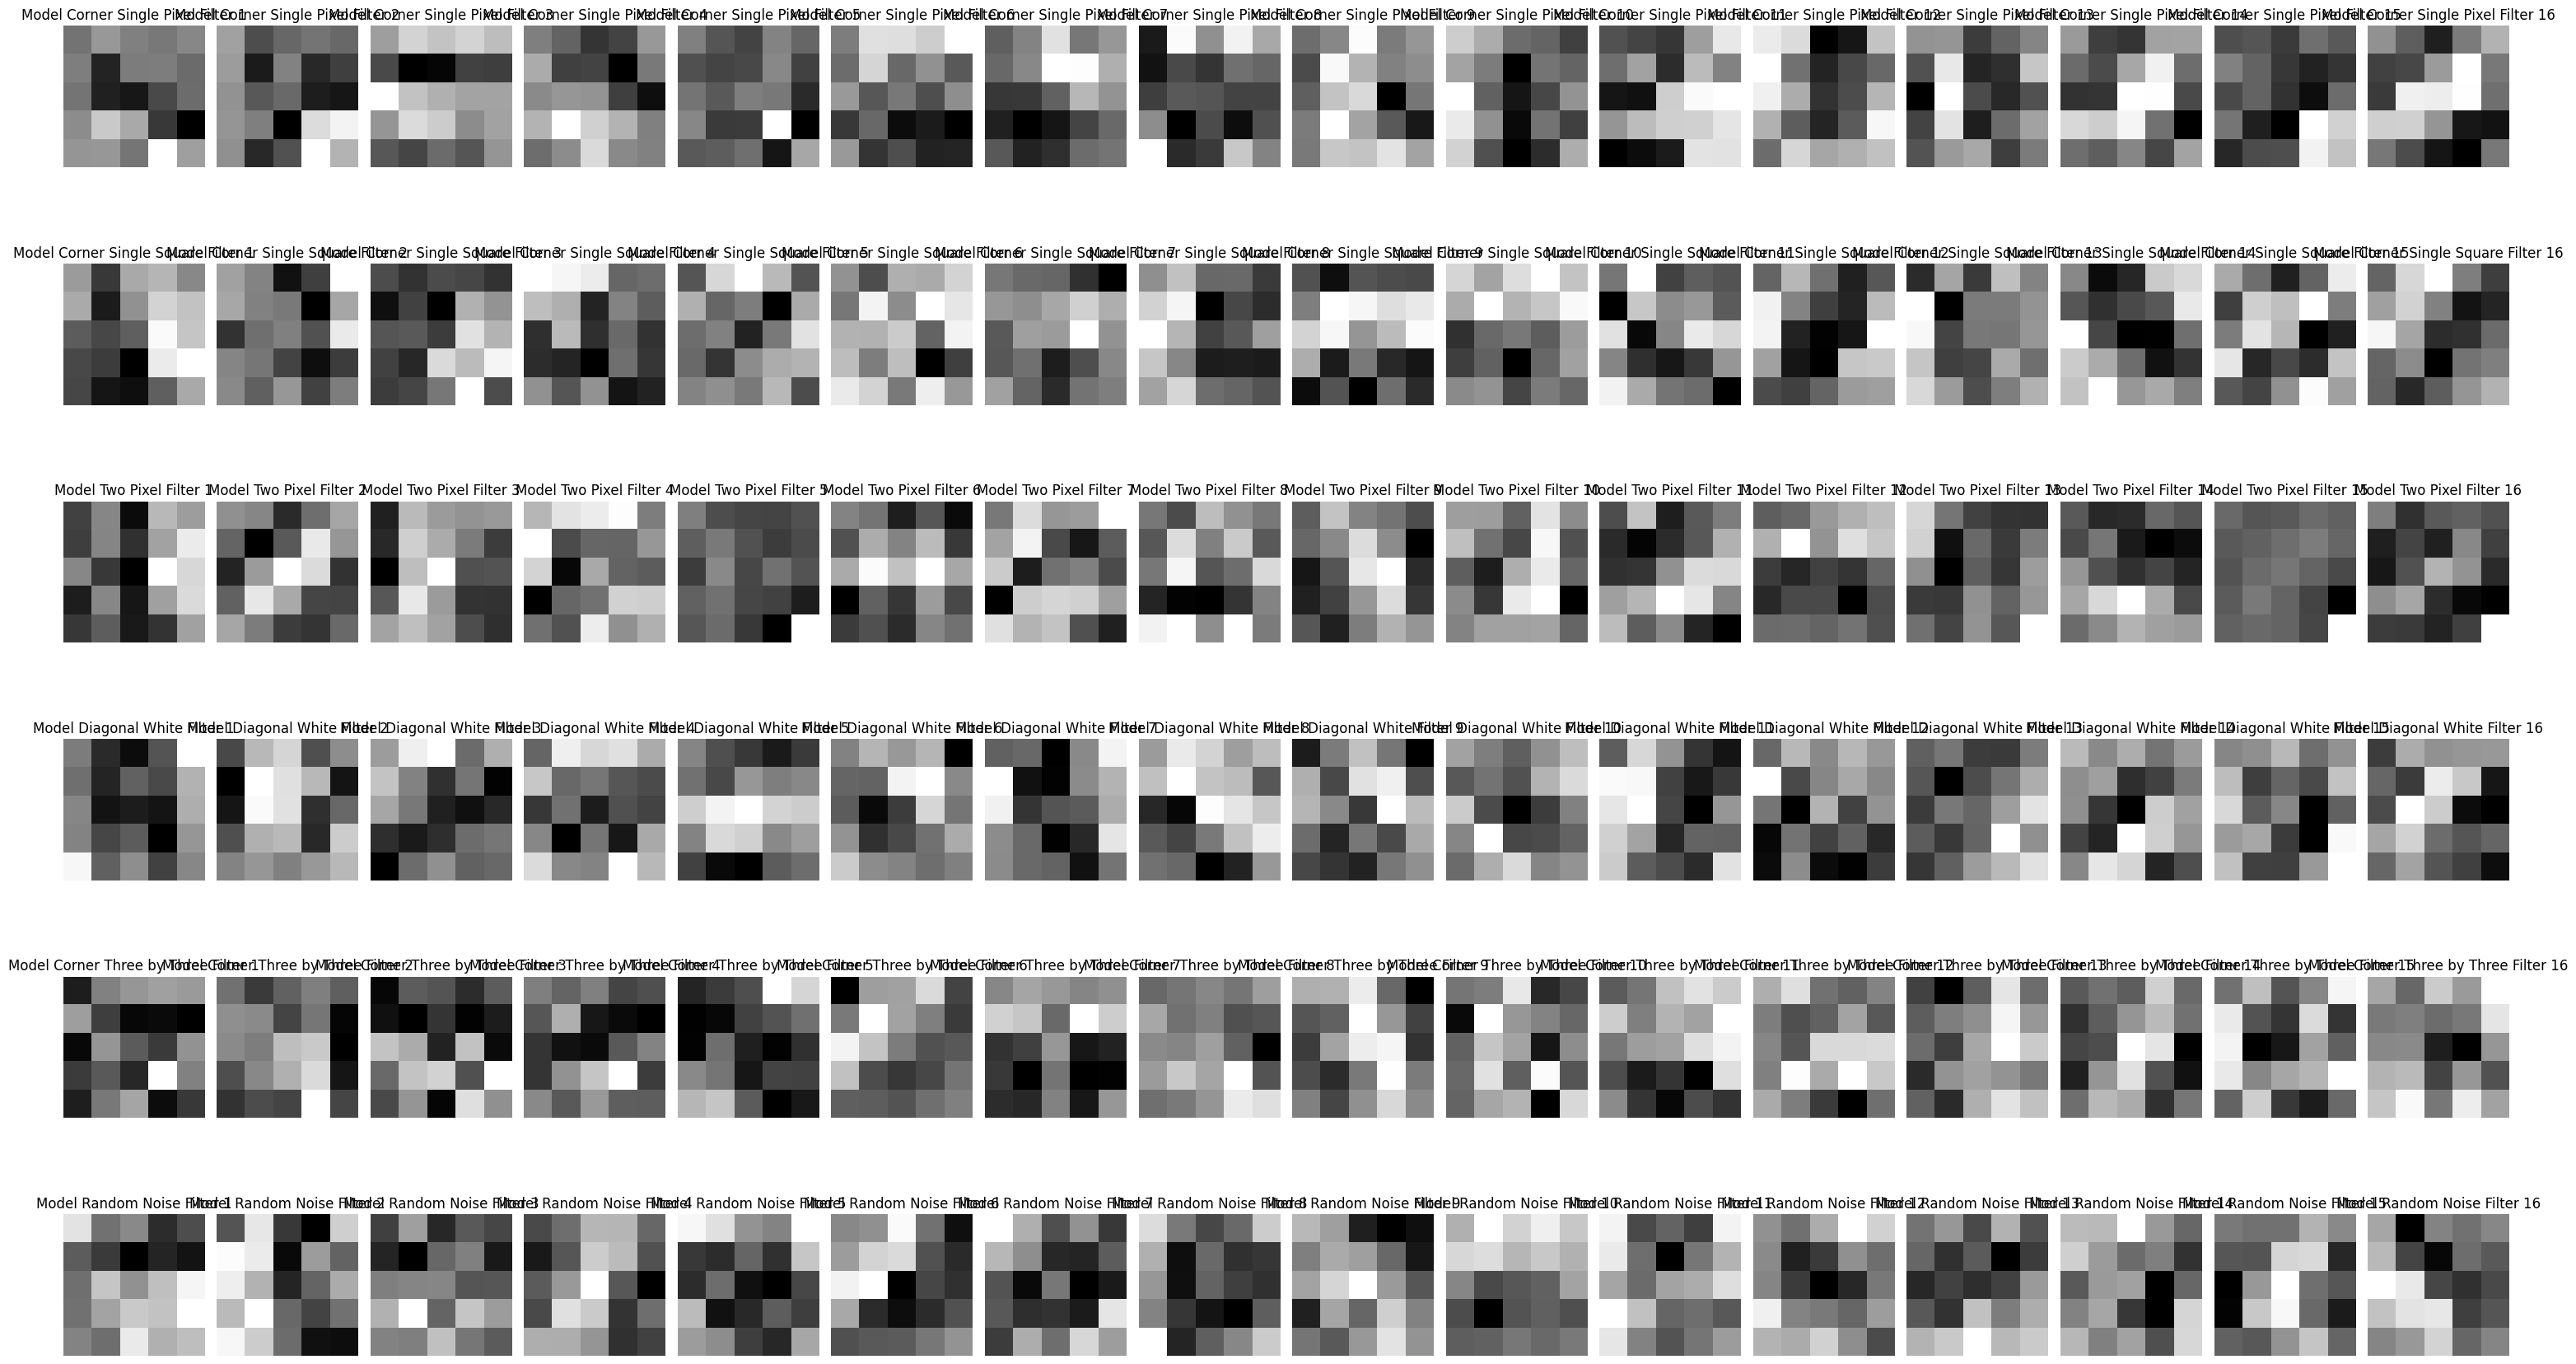

In [118]:
visualize_models_filters(models) 

some patterns are evident here, but it's not enough for us to continue our investigation with feature map visualization. 

In [122]:
trigger_names = list(trigger_dict.keys())

def plot_all_losses_in_one(results_clean, trigger_names):
    epochs = range(1, len(results_clean[0]) + 1)

    plt.figure(figsize=(12, 8))

    for i, losses in enumerate(results_clean):
        plt.plot(epochs, losses, label=trigger_names[i])

    plt.title('Test Losses Over Epochs for Different Triggers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    

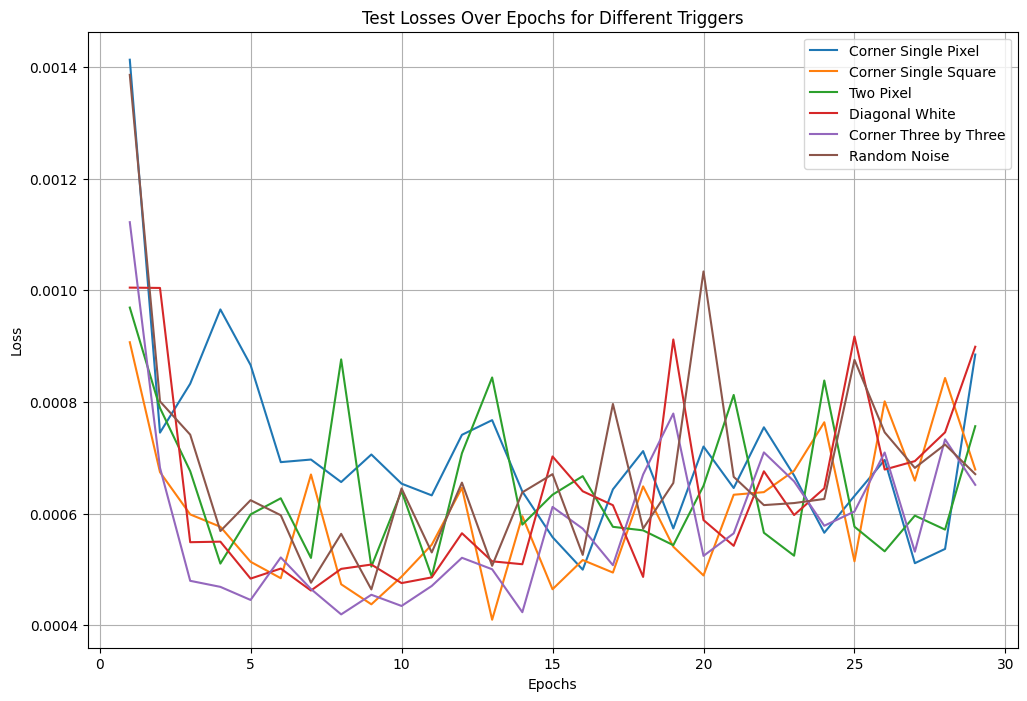

In [122]:
plot_all_losses_in_one(results_clean, trigger_names)

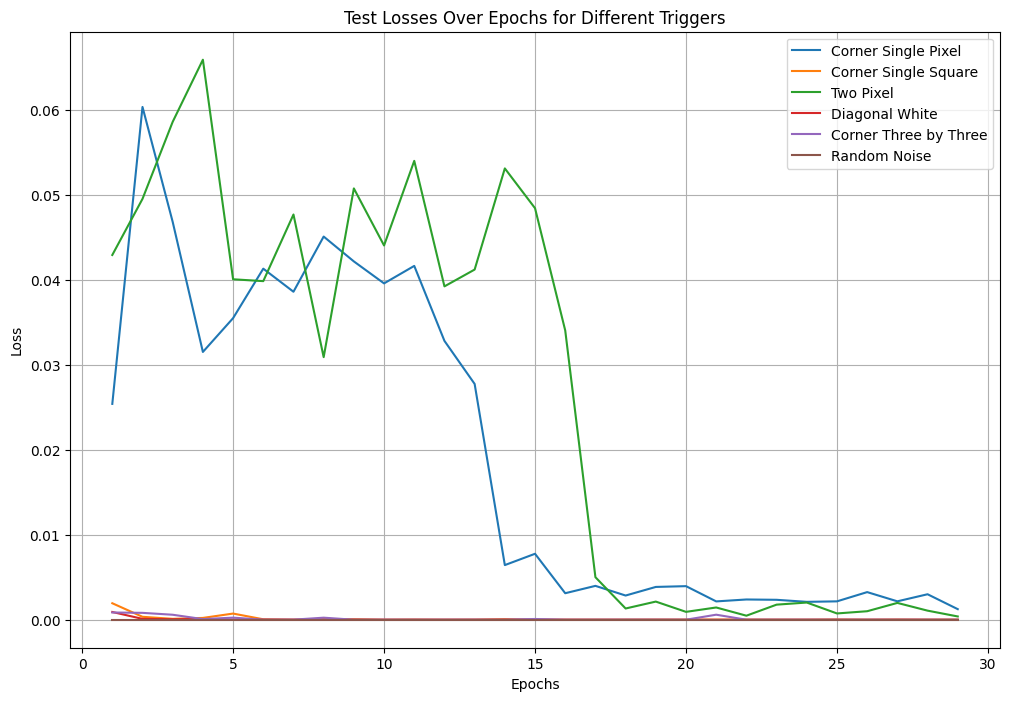

In [123]:
plot_all_losses_in_one(results_poisoned, trigger_names)

let's see how far we can go with random noise 